# **Trabajo final: Aplicando y comparando regresión LASSO y Random Forest para predecir el precio de viviendas**

**Integrantes**: Angie Vega (20202068), Cristofer Silva (20203098), Rodrigo Flores (20203916) y Brisa Cruz (20201121).

Este script explora y modela un conjunto de datos, comparando dos algoritmos usados en el curso (LASSO regression y RF). Nos basamos en dos scripts: https://github.com/christinasam/House-Price-Prediction y https://github.com/shaadclt/Boston-House-Price-Prediction-LassoRegression

Si bien inicialmente pretendíamos usar un conjunto de datos peruano, elegimos el clásico Boston Housing por su disponibilidad pública y porque ilustra bien los retos básicos de regresión (multicolinealidad, no linealidades, sesgo de escala). El guion sigue la lógica de un pipeline reproducible: (1) descarga y limpieza del dataset, (2) análisis exploratorio con visualizaciones clave, (3) selección de variables mediante regresión Lasso, (4) estimación de un modelo no lineal con Random Forest, (5) validación cruzada y métricas de desempeño, y (6) conclusiones críticas sobre precisión, interpretabilidad y limitaciones.

Más allá de cumplir con los requisitos técnicos del curso (manipulación con pandas, gráficos con matplotlib/seaborn, modelos de scikit‑learn y evaluación de errores), el cuaderno busca mostrar buenas prácticas de investigación aplicada: código comentado en primera persona plural, hiperparámetros fijados por validación cruzada, métricas complementarias para medir magnitud y sesgo, y reflexiones sobre la adecuación ética del dataset. Así, cualquier lector con conocimientos básicos de Python puede rehacer los pasos, reproducir los resultados e incluso transferir la receta a un conjunto de datos más actual sin depender de los autores originales.

El Boston Housing Dataset se originó a partir de un estudio realizado por David
Harrison y Daniel L. Rubinfeld, publicado en 1978 con el título "Hedonic housing
prices and the demand for clean air". Este dataset incluye información sobre 506
vecindarios en Boston, con un total de 14 variables, y será utilizado para
desarrollar un modelo que prediga el precio medio de las viviendas.

In [ ]:
## Las variables que se utilizan son las siguientes:

## Características del dataset:

    #• CRIM: Tasa de criminalidad per cápita por ciudad.
    #• ZN: Proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados.
    #• INDUS: Proporción de acres de negocios no minoristas por ciudad.
    #• CHAS: Variable ficticia de Charles River (= 1 si el tramo limita con el río; 0 en caso contrario).
    #• NOX: Concentración de óxidos nítricos (partes por 10 millones).
    #• RM: Número medio de habitaciones por vivienda.
    #• AGE: Proporción de unidades ocupadas por propietarios construidas antes de 1940.
    #• DIS: Distancias ponderadas a cinco centros de empleo en Boston.
    #• RAD: Índice de accesibilidad a carreteras radiales.
    #• TAX: Tasa de impuesto a la propiedad de valor total por $10,000.
    #• PTRATIO: Proporción alumno-maestro por ciudad.
    #• B: 1000(Bk - 0.63)^2, donde Bk es la proporción de personas de ascendencia afroamericana por ciudad.
    #• LSTAT: Porcentaje de la población de menor estatus.
    #• PRICE: Mediana del valor de las casas ocupadas por sus propietarios en $1000.

## 1. Comencemos con un analisis exploratorio de los datos:
    ## Antes de proceder con el modelado, es esencial realizar un análisis exploratorio de datos (EDA). A continuación, se proporciona un código inicial para cargar el dataset en su entorno de trabajo:


# Sección 1: Comencemos con un analisis exploratorio de los datos:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# URL del dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"

In [ ]:
# Leer el archivo de datos
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

In [ ]:
# Combinar los datos
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

df = pd.DataFrame(data, columns=[
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
])
df['PRICE'] = target

In [ ]:
# Mostrar las primeras filas del DataFrame
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
# Obtener un resumen estadístico del dataset
resumen_estadistico = df.describe()
print("Resumen estadístico:")
print(resumen_estadistico)

print("\n" + "-" * 50 + "\n")

Resumen estadístico:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std   

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [ ]:
# Obtener una descripción general del dataset
descripcion_general = df.info()
print("Descripción general:")
print(descripcion_general)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
Descripción general:
None


In [ ]:
## Valores faltantes
valores_faltantes = df.isnull().sum()
print("Valores faltantes en cada columna:")
print(valores_faltantes)

Valores faltantes en cada columna:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


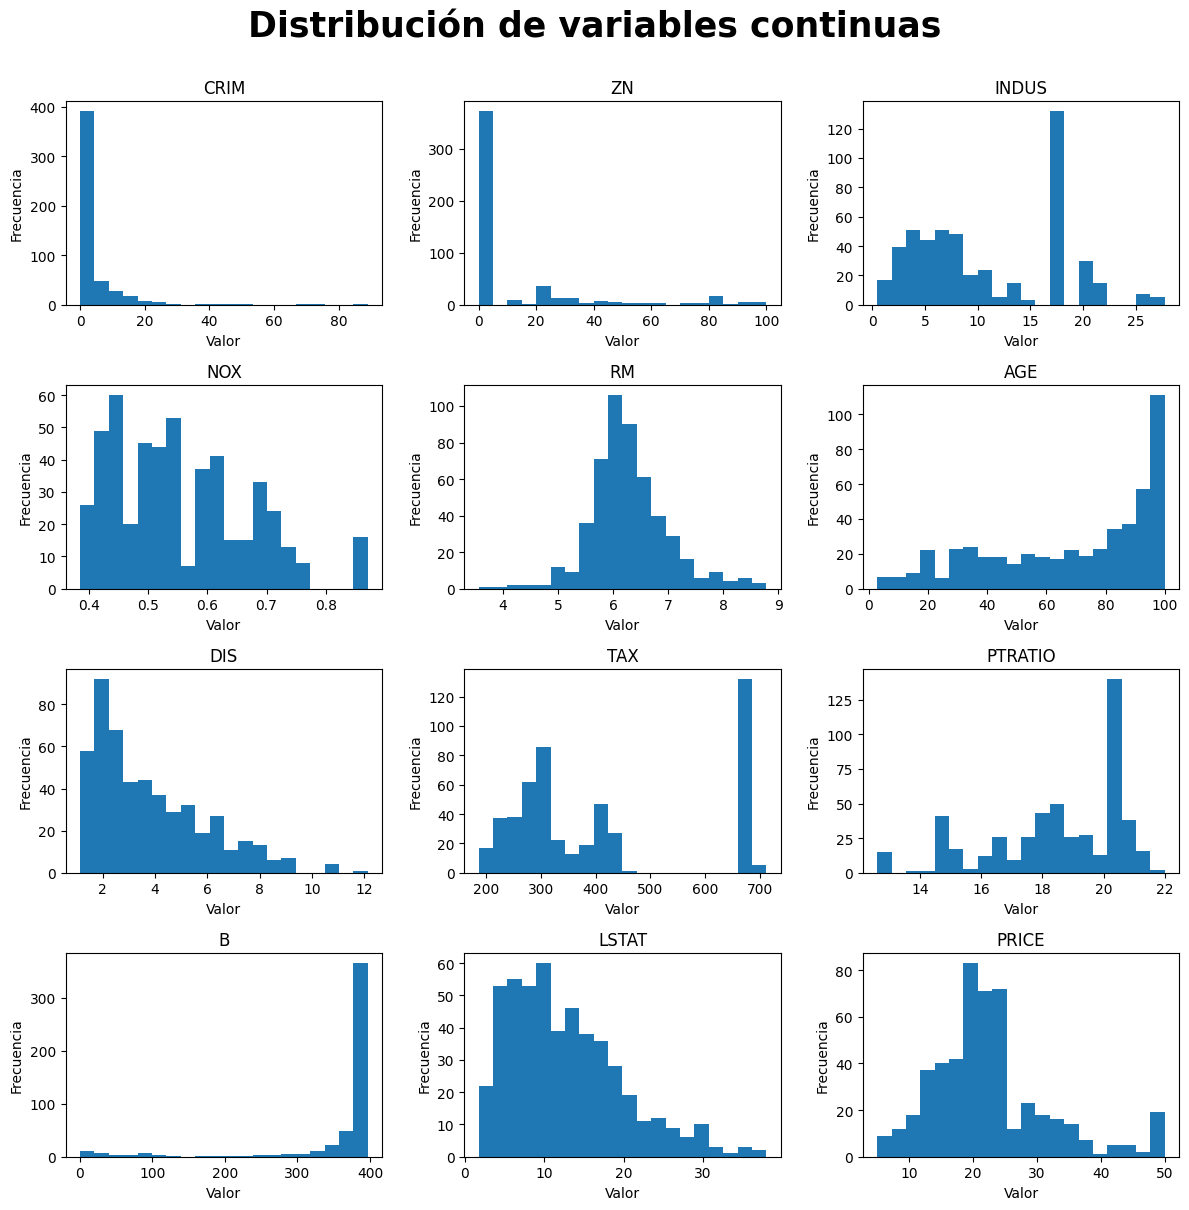

In [ ]:
# Visualizar la distribución de las variables continuas mediante histogramas
columnas_continuas = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']

fig, axs = plt.subplots(4, 3, figsize=(12, 12))
axs = axs.flatten()

for i, columna in enumerate(columnas_continuas):
    axs[i].hist(df[columna], bins=20)
    axs[i].set_title(columna)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frecuencia')

# Titulo del gráfico
fig.suptitle('Distribución de variables continuas', fontsize=25, fontweight='bold', y=1.005)

## Mostrarlo
plt.tight_layout()
plt.show()

* En el primer gráfico, CRIM (tasa de criminalidad per cápita por ciudad) la distribución está muy sesgada a la derecha, es decir, una asimetría positiva: la mayoría de los barrios tienen muy baja criminalidad; sin embargo, existen algunos valores muy altos (outliers extremos)
* Para el siguiente gráfico ZN (proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados) presenta también un sesgo hacia la derecha, casi todos los barrios tienen ZN=0, no están zonificados para grandes terrenos. Solo unos pocos tienen valores altos. En otras palabras, es una variable muy desigual.
* El siguiente gráfico, INDUS (proporción de acres de negocios no minoristas por ciudad) presenta una distribución multimodal con una fuerte acumulación en torno a 18%. Esto puede indicar zonas claramente diferenciadas: residenciales e industriales.
* El gráfico NOX (concentración de óxidos nítricos) presenta una distribución dispersa con tendencia a la derecha. Existen muchos valores en el rango 0.4-0.7 pero también hay barrios más contaminados con valores de más de 0.8
* Luego, tenemos el gráfico RM (número medio de habitaciones por vivienda) que presenta una distribución similar a una gaussiana, es decir, aproximadamente normal, con una media de 6 habitaciones.
* El gráfico AGE (proporción de unidades ocupadas por propietarios construidas antes de 1940) presenta un sesgo hacia la izquierda (negativo), es decir, existen muchas casas antiguas, mucha representatividad de AGE=100.

* En ese sentido, pocos barrios tienen construcciones recientes.  
En el siguiente gráfico, DIS (distancias ponderadas a cinco metros de empelo de Boston) presenta una distribución sesgada a la derecha. La mayoría de las viviendas están relativamente cerca de los centros de empleo. Existen pocas observaciones con grandes distancias.




*  El gráfico TAX (tasa de impuesto a la propiedad de valor total por $10,000) presenta una distribución multimodal con un pico fuerte cerca de 660-700. También hay grupos en 200-300 y otro en 300-400.
*   También tenemos el gráfico PTRATO (proporción alumno-maestro por ciudad) con una distribución de pico muy marcado en el punto 20.5 (aproximadamente). Por otro lado, el rango de 12 a 16 tiene pocas observaciones.


*   El gráfico B (proporción de población africana) presenta un sesgo fuerte a la izquierda: muchas observaciones están muy cerca del valor máximo. Muy pocas viviendas en áreas con alta población afroamericana.
*   La distribución del gráfico LSTAT (porcentaje de la población de menor estatus) se presenta sesgada a la derecha, es decir, la mayoría de las zonas tienen baja pobreza, pero algunas llegan a más del 30%.


*  Por último, la distribución de PRICE (mediana del valor de las casas ocupadas por sus propietarios en $1000) es asimétrica a la derecha con una acumulación entre los 20 y 25 mil dólares. Se da a la vez un tope artificial de 50.








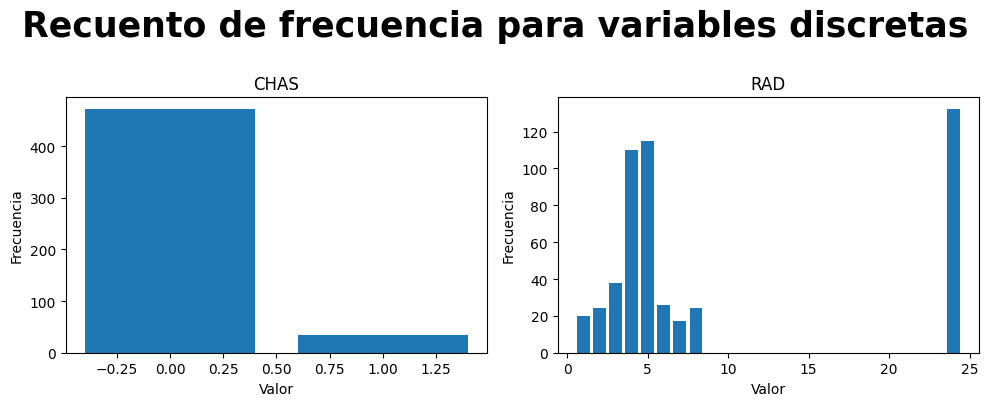

In [ ]:
# Visualizar los recuentos de frecuencias para las variables discretas
columnas_discretas = ['CHAS', 'RAD']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, columna in enumerate(columnas_discretas):
    recuentos = df[columna].value_counts()
    axs[i].bar(recuentos.index, recuentos.values)
    axs[i].set_title(columna)
    axs[i].set_xlabel('Valor')
    axs[i].set_ylabel('Frecuencia')

# Titulo del gráfico
fig.suptitle('Recuento de frecuencia para variables discretas', fontsize=25, fontweight='bold', y=1.005)

## Mostrar
plt.tight_layout()
plt.show()


En el gráfico se busca visibilizar la frecuencia (cantidad de veces que aparece cada valor). En este caso, para las variables discretas CHAS y RAD. Por un lado, la variable CHAS (variable ficticia del río Charles con valor igual a 1 si el tramo limita con el río e igual a 0 en caso contrario), se observa que el valor de 0 tiene una frecuencia de más de 450 observaciones, mientras que el valor de 1 tiene una frecuencia mucho menor (entorno a 30-40). Esto sugiere que muy pocos tramos colindan con el río Charles. Por otro lado, la variable RAD (que indica el índice de accesibilidad a carreteras radiales con valores que van del 1 al 24) indica que hay varios valores con frecuencias moderadas (hasta 9), mientras que el valor de 24 tiene mucha más representatividad con aproximadamente 130. Esto nos indica que muchas viviendas agrupadas en zonas con el mismo nivel de accesibilidad vial que es probablemente por el diseño urbano.

In [ ]:
# Definimos las variables numéricas
variables_numericas = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']

In [ ]:
# Establecemos el estilo de Seaborn
sns.set(style='whitegrid')

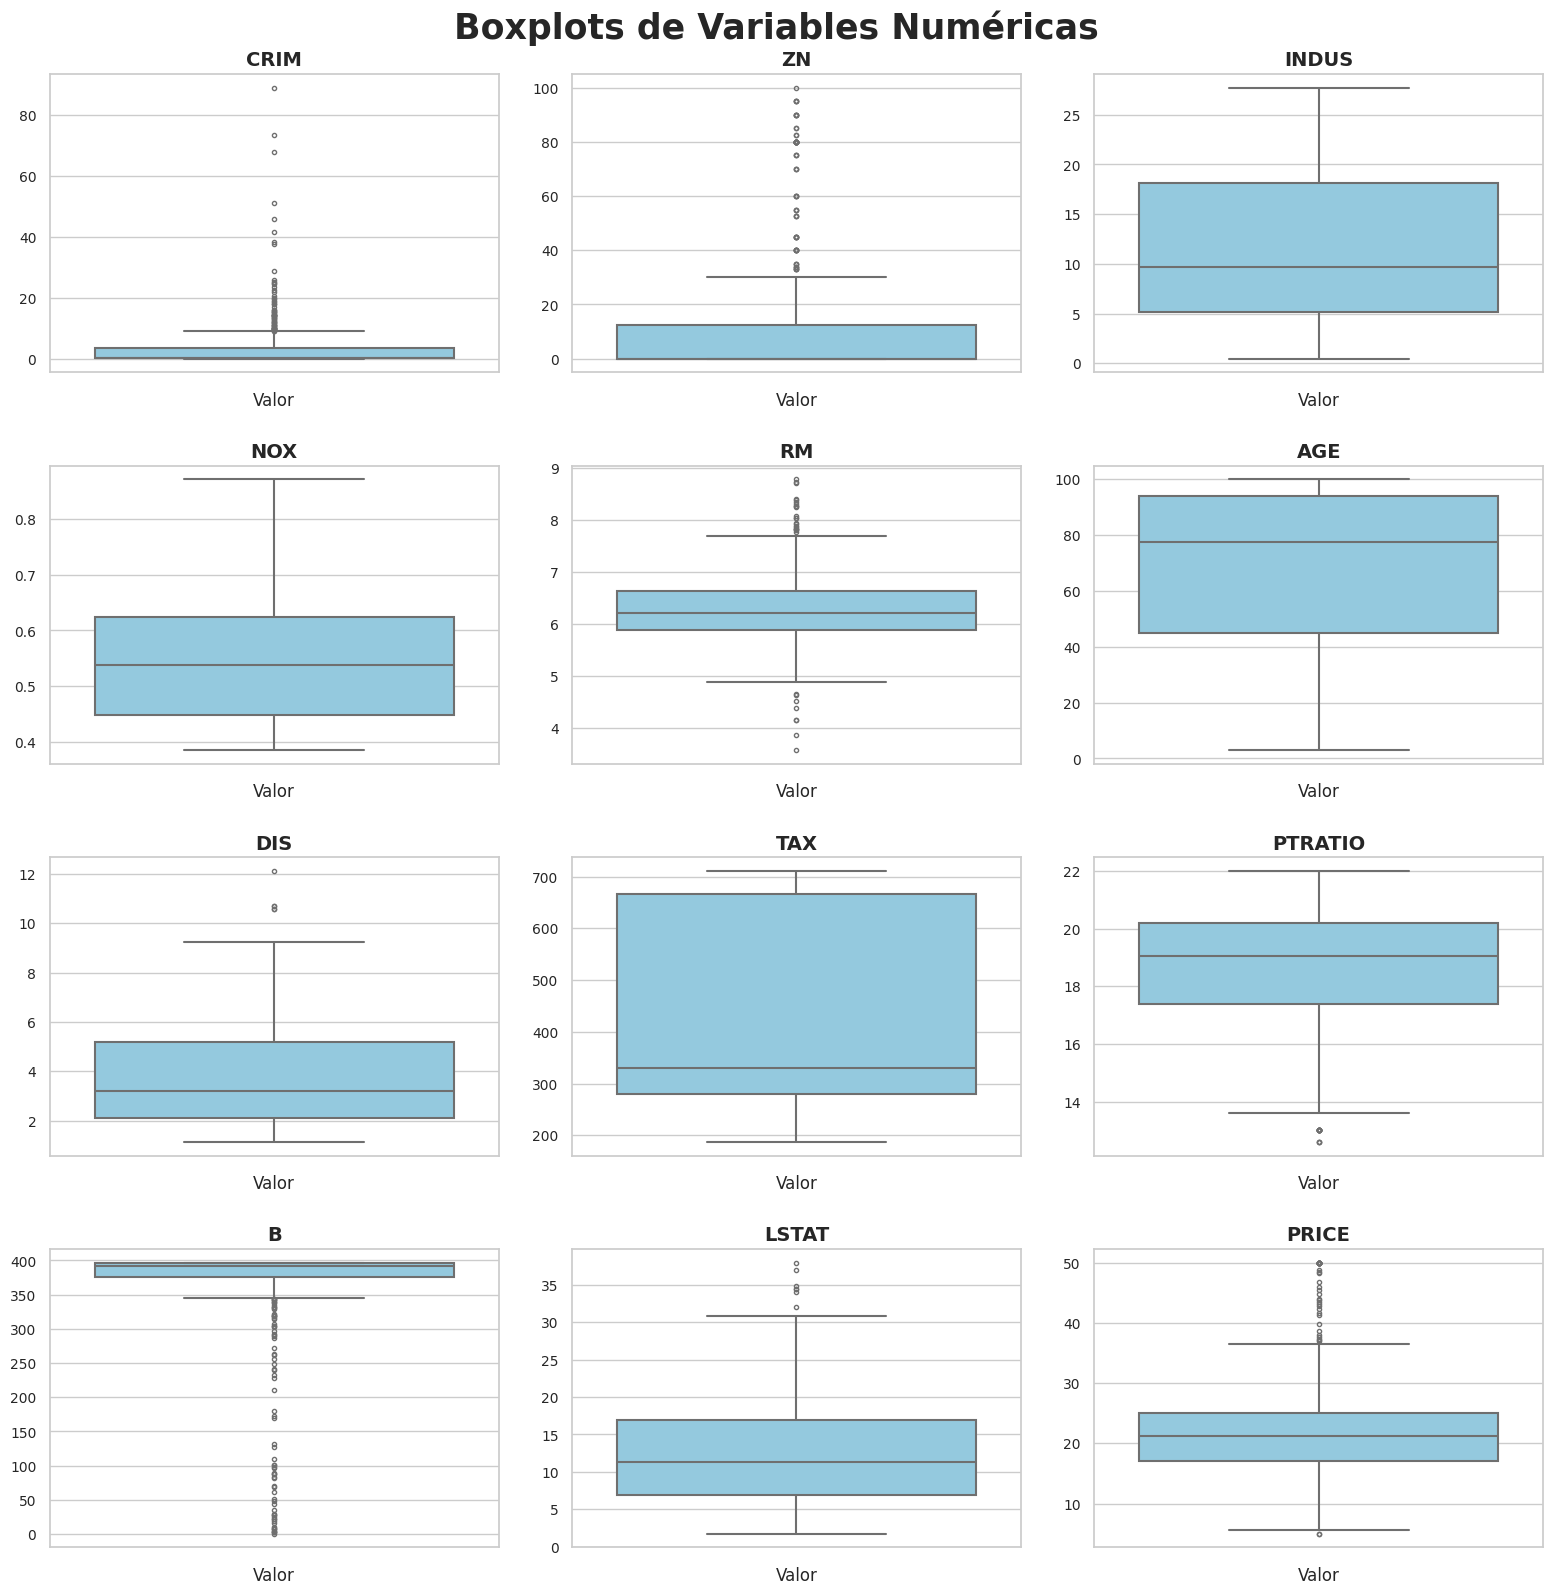

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))
axs = axs.flatten()

# Generar boxplots para cada variable numérica
for i, variable in enumerate(variables_numericas):
    sns.boxplot(y=df[variable], ax=axs[i], color='skyblue', linewidth=1.5, fliersize=3)
    axs[i].set_title(variable, fontsize=14, fontweight='bold')
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Valor', fontsize=12)
    axs[i].tick_params(labelsize=10)

# Ajustar el espaciado entre los subplots
plt.tight_layout(pad=2)

# Titulo del gráfico
fig.suptitle('Boxplots de Variables Numéricas', fontsize=25, fontweight='bold', y=1.005)

# Mostrarlo
plt.show()

1. CRIM (Tasa de criminalidad per cápita)
La mayoría de los barrios tienen una tasa de criminalidad baja, lo cual es alentador, pero hay algunos sectores que presentan niveles extremadamente altos. Estos valores extremos o outliers sugieren zonas muy conflictivas o inseguras. Este comportamiento evidencia que en Boston existe una fuerte desigualdad en cuanto a la seguridad en distintas zonas urbanas.
2. ZN (Proporción de terrenos residenciales grandes)
Predominan los barrios donde no existen terrenos grandes designados para residencias exclusivas, es decir, la zonificación para grandes lotes es poco común. Sin embargo, algunos barrios sí cuentan con zonas muy extensas destinadas a residencias, aunque son la minoría. Esto refleja la diversidad urbanística en la ciudad.

3. INDUS (Proporción de zona industrial) La mayoría de barrios tiene un porcentaje relativamente bajo de zonas industriales, pero algunas áreas destacan por su alto nivel de industrialización. Esto sugiere que Boston aún conserva zonas específicas fuertemente orientadas a la industria.

4. NOX (Contaminación por óxidos nítricos)
La contaminación atmosférica presenta valores relativamente moderados, pero existe un grupo de barrios donde los niveles de NOX son preocupantes. Esto, además de afectar la calidad de vida, puede tener un impacto directo en la valorización de las viviendas.

5. RM (Número medio de habitaciones por vivienda)
La distribución es bastante regular y simétrica, aunque se identifican algunas casas de lujo con más de 8 habitaciones, que son excepcionales. Generalmente, más habitaciones están asociadas a viviendas de mayor precio, lo que es intuitivo en un mercado inmobiliario.

6. AGE (Proporción de viviendas antiguas)
Hay una marcada tendencia hacia viviendas antiguas, ya que muchas fueron construidas antes de 1940. Esto denota la antigüedad de algunas zonas tradicionales de Boston, aunque también persisten áreas con desarrollos más modernos.

7. DIS (Distancia a centros de empleo)
Las distancias a los centros de empleo varían bastante. Algunas zonas están bien conectadas, mientras que otras se encuentran considerablemente alejadas, lo que podría afectar su atractivo dependiendo de la facilidad de acceso y transporte.

8. TAX (Tasa de impuesto predial) La mayoría de barrios paga un impuesto predial moderado, aunque algunos enfrentan cargas tributarias significativamente más altas. Esto puede relacionarse con la infraestructura disponible o la valorización del suelo.

9. PTRATIO (Proporción alumno/maestro)
La calidad educativa, medida inversamente por este ratio, tiene valores bastante concentrados. Los barrios con menores ratios suelen asociarse con mejor calidad educativa, un factor importante en la elección de vivienda para familias.

10. B (Proporción ajustada de población afroamericana)
La mayoría de valores está cerca del máximo, lo que implica una baja proporción de población afroamericana en muchos barrios. Esta variable está construida de forma cuadrática, lo que puede dificultar una interpretación directa, pero refleja tensiones o segregaciones raciales latentes en la ciudad.

11. LSTAT (Porcentaje de población de bajo estatus económico)
Hay barrios con un bajo porcentaje de población en condición de vulnerabilidad, aunque algunos concentran niveles preocupantes de pobreza. Estos últimos son los que suelen tener precios de vivienda más bajos.

12. PRICE (Precio de las viviendas) La distribución de precios se centra entre 15k y 25k USD, pero existen viviendas excepcionales que superan esos valores, reflejando las disparidades económicas en Boston. También hay viviendas de bajo costo que probablemente se sitúan en zonas con desventajas sociales o ambientales.



In [ ]:
## MATRIZ DE CORRELACIÓN

## Calculamos la matriz
correlation_matrix = df.corr()

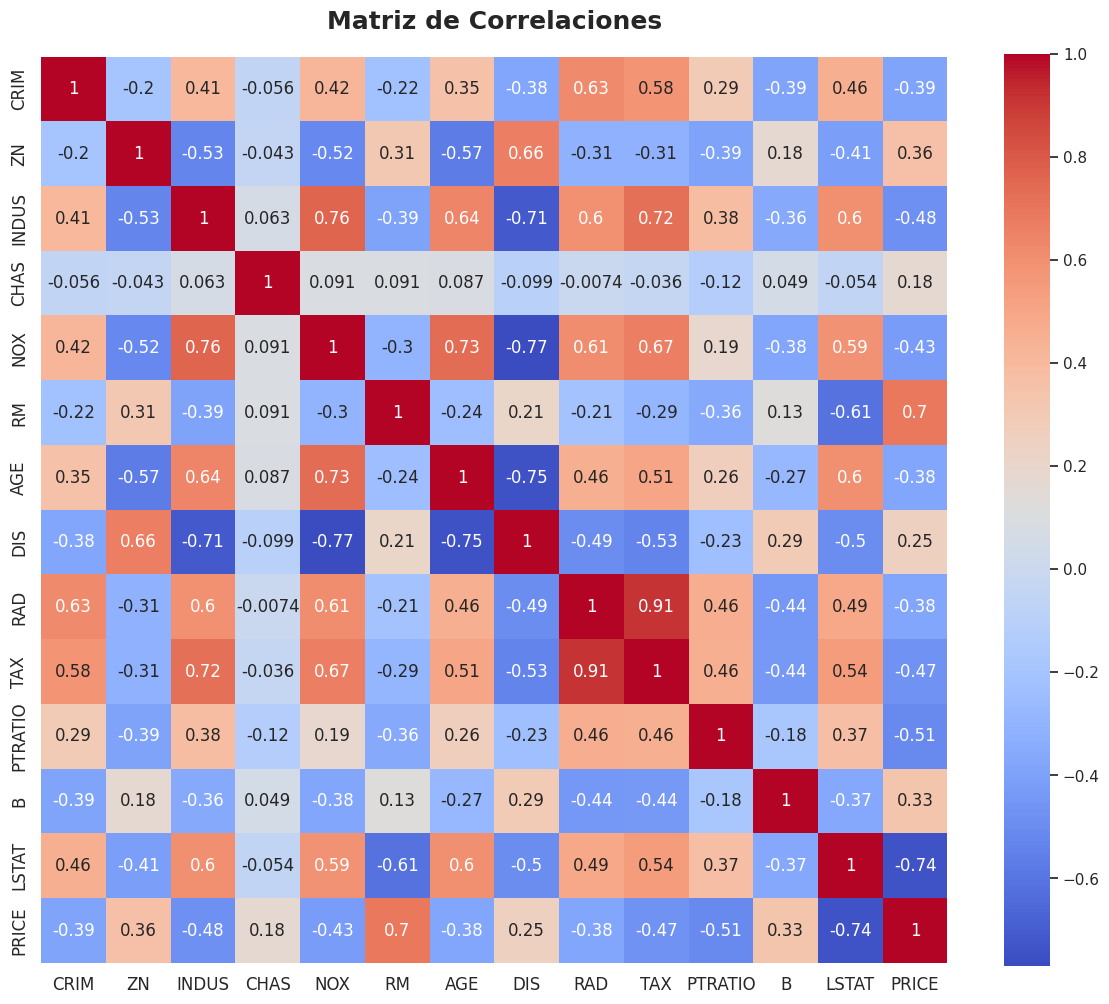

In [ ]:
## Creemos una figura y un cojunto de subplots para la matriz establecida
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, ax=ax)
ax.set_title('Matriz de Correlaciones', fontsize=18, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=12)
plt.tight_layout()

## Mostremos
plt.show()

* LSTAT y PRICE (-0.74): Existe una fuerte correlación negativa. Esto significa que en la medida que aumenta la proporción de población con menor estatus económico en un barrio, el precio de las viviendas tiende a caer de manera significativa. Esto evidencia la influencia del componente social y económico en la valorización inmobiliaria.
* RM y PRICE (+0.70): Hay una relación positiva muy fuerte entre el número de habitaciones promedio y el precio de la vivienda. A mayor tamaño y amplitud de la vivienda, mayor es su valor de mercado, lo cual es lógico y esperado.
* PTRATIO y PRICE (-0.51): Los barrios con peor proporción alumno-maestro, es decir, con peor calidad educativa, tienden a tener precios de viviendas más bajos. Este resultado resalta la importancia de la educación como factor determinante del valor inmobiliario.
* NOX y PRICE (-0.43): La contaminación ambiental tiene un impacto claro en el precio: mientras más contaminado el aire, más barata suele ser la vivienda en esa zona.
* CRIM y PRICE (-0.39): Como era de esperarse, la criminalidad también reduce significativamente el valor de las viviendas. La seguridad es un factor clave al momento de comprar o invertir en una propiedad.

Otros vínculos relevantes:

* INDUS y NOX (0.76): La relación positiva indica que las zonas con más industria también tienen mayores niveles de contaminación.
* TAX y RAD (0.91): Existe una relación casi perfecta entre los impuestos prediales y la accesibilidad a carreteras radiales, posiblemente porque el desarrollo de infraestructura vial afecta la carga tributaria y la zonificación.
* RM y LSTAT (-0.61): Las casas con menos habitaciones suelen estar en zonas de menor estatus económico.



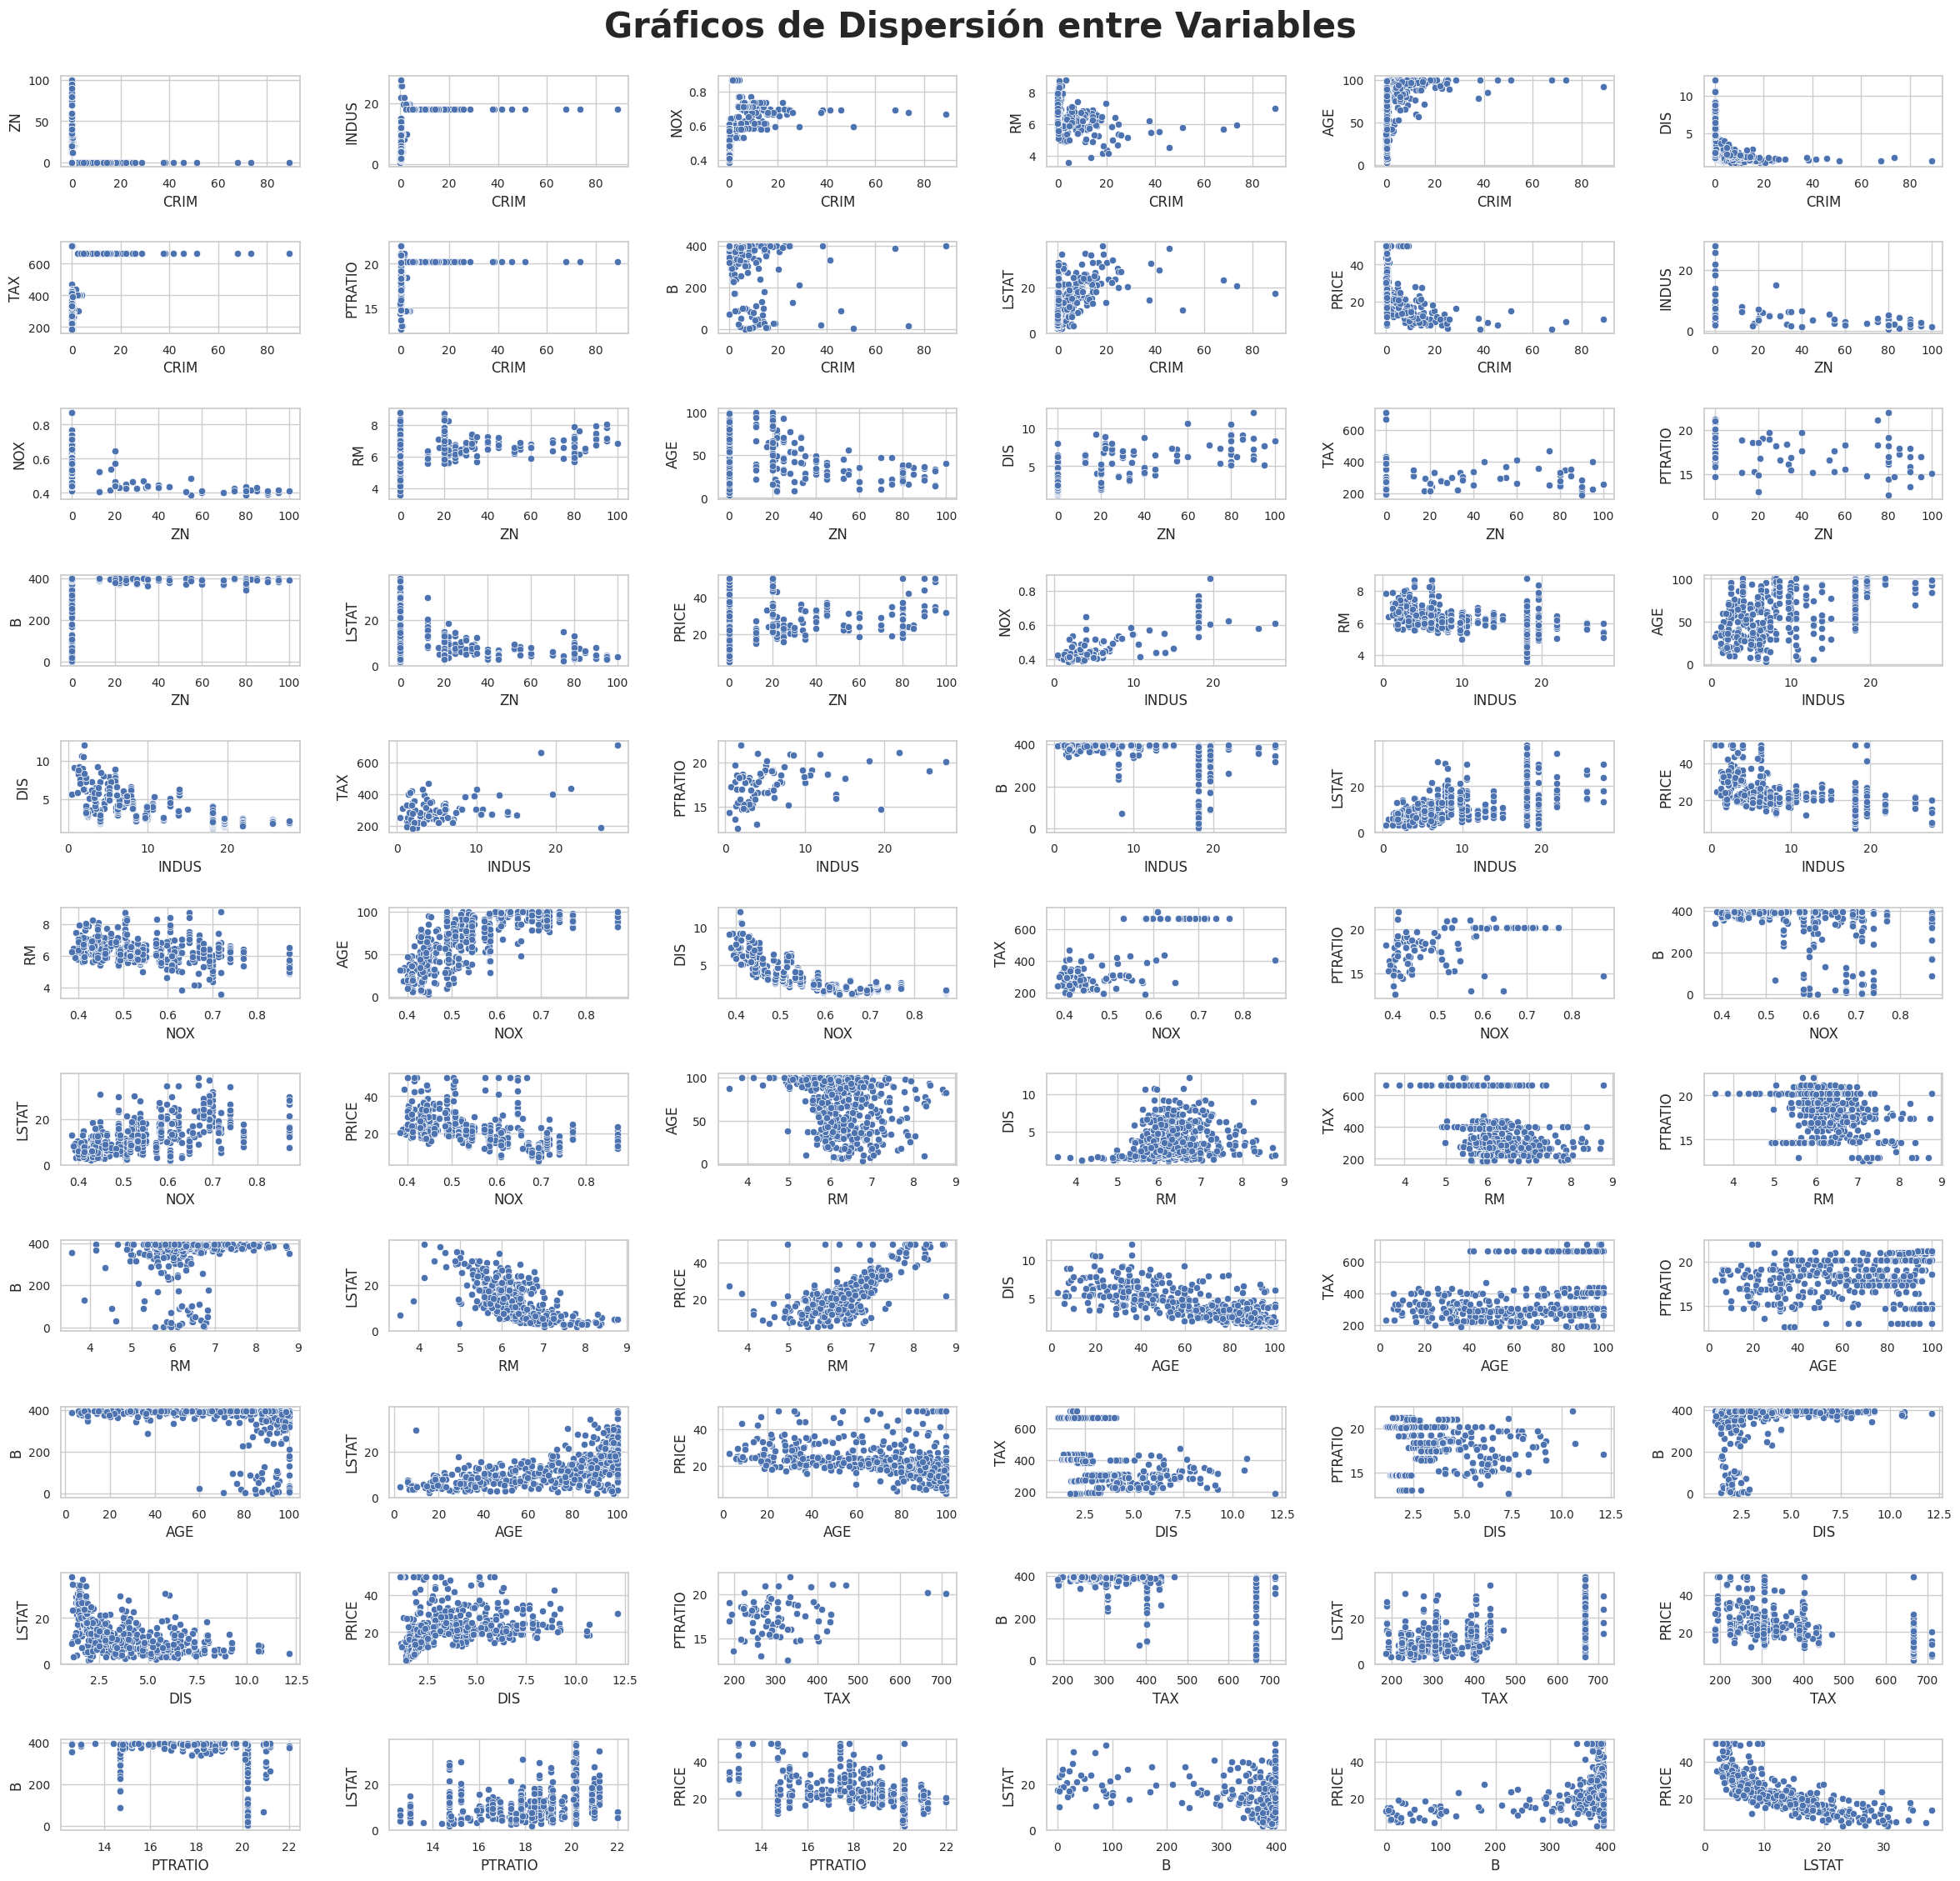

In [ ]:
## Vamos a armar un gráfico de disperción ahora

fig, axs = plt.subplots(12, 6, figsize=(24, 24))
axs = axs.flatten()

# Lista de variables
variables = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']

# Graficos de disperción
index = 0
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            sns.scatterplot(x=df[var1], y=df[var2], ax=axs[index])
            axs[index].set_xlabel(var1, fontsize=12)
            axs[index].set_ylabel(var2, fontsize=12)
            axs[index].tick_params(labelsize=10)
            index += 1

plt.tight_layout(pad=2)

# Eliminamos subplots vacíos
for ax in axs[index:]:
    fig.delaxes(ax)

# Titulo
fig.suptitle('Gráficos de Dispersión entre Variables', fontsize=30, fontweight='bold', y=1.02)

# Mostrar
plt.show()

1. NOX vs RM (Número promedio de habitaciones por vivienda):
* Observamos una relación negativa: a mayor concentración de NOX (más contaminación), el número promedio de habitaciones por vivienda tiende a disminuir.
* Esto sugiere que en zonas más contaminadas las casas suelen ser más pequeñas, probablemente porque estas áreas son más industriales o de menor calidad residencial.

2. NOX vs AGE (Proporción de viviendas construidas antes de 1940):
* Hay una tendencia positiva: a mayor NOX, mayor es la proporción de viviendas antiguas.
* Esto puede indicar que las zonas más contaminadas son también aquellas con viviendas más viejas, quizá porque están cerca de focos industriales históricos o porque no se han renovado ni modernizado las construcciones.

3. NOX vs DIS (Distancia a centros de empleo):
* Existe una clara relación negativa: cuando la contaminación (NOX) es alta, la distancia a los centros de empleo tiende a ser menor.
* Esto tiene sentido porque las zonas cercanas a áreas industriales o centros urbanos suelen estar más contaminadas, mientras que las áreas suburbanas (más alejadas) son más limpias.

4. NOX vs TAX (Tasa de impuesto predial):
* Se observa una relación positiva leve: a mayor NOX, también hay zonas con tasas impositivas más altas.
* Esto podría reflejar que algunas áreas industriales o centrales, a pesar de la contaminación, tienen infraestructura o servicios que incrementan el impuesto predial.

5. NOX vs PTRATIO (Proporción alumno/maestro):
* La relación aquí es menos clara, pero se percibe que en zonas con contaminación moderada a alta hay mayor dispersión en el ratio alumno/maestro.
* Aun así, parece que zonas con mayor contaminación no necesariamente tienen la mejor calidad educativa, aunque no es una relación fuerte ni lineal.

## Sección 2 : Preparación de los datos para estimación de un modelo de regresión

In [ ]:
## 2. Preparación de los datos para estimación de un modelo de regresión
# Identificar las columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print('Columnas categóricas:', categorical_cols)

Columnas categóricas: Index([], dtype='object')


In [ ]:
# Dummy para CHAS
chas_dummies = pd.get_dummies(df['CHAS'], prefix='CHAS')

# Unir las variable dummy al DataFrame original
df = pd.concat([df, chas_dummies], axis=1)
df.drop('CHAS', axis=1, inplace=True)

# Lista de columnas con tipo de dato no numérico
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

# Convertir cada columna no numérica
for col in non_numeric_cols:
    df[col] = df[col].astype(int)

print("DataFrame con variables dummy:")
print(df.head())

DataFrame con variables dummy:
      CRIM    ZN  INDUS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  1.0  296.0     15.3   
1  0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   
2  0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  2.0  242.0     17.8   
3  0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  3.0  222.0     18.7   
4  0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  3.0  222.0     18.7   

        B  LSTAT  PRICE  CHAS_0.0  CHAS_1.0  
0  396.90   4.98   24.0         1         0  
1  396.90   9.14   21.6         1         0  
2  392.83   4.03   34.7         1         0  
3  394.63   2.94   33.4         1         0  
4  396.90   5.33   36.2         1         0  


In [ ]:
## Encontramos las columnas con datos no númericos
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns

## Convertimos cada columna no numérica
for col in non_numeric_cols:
    if df[col].dtype == 'object':
        # Columna de tipo objeto (cadena de texto)
        df[col] = df[col].astype('category').cat.codes
    else:
        # Otro tipo de dato no numérico
        df[col] = pd.to_numeric(df[col], errors='coerce')


print("Tipos de datos después de la conversión:")
print(df.dtypes)

Tipos de datos después de la conversión:
CRIM        float64
ZN          float64
INDUS       float64
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD         float64
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
PRICE       float64
CHAS_0.0      int64
CHAS_1.0      int64
dtype: object


In [ ]:
## Para la estimación inicial, se separó el conjunto de datos en X (características) e Y (variable objetivo), considerando todas las variables disponibles excepto 'PRICE', que se definió como el target. Posteriormente, se dividió el conjunto en datos de entrenamiento y prueba utilizando la función `train_test_split` de Scikit-Learn, empleando una proporción de **80/20** para garantizar un entrenamiento adecuado y una evaluación robusta del modelo.

# Separar las características (X) y la variable objetivo (y)
X = df.drop(columns = ['PRICE'], axis=1)
y = df['PRICE']

print("Características (X):")
print(X)
print("\nTarget (y):")
print(y)


Características (X):
        CRIM    ZN  INDUS    NOX     RM   AGE     DIS  RAD    TAX  PTRATIO  \
0    0.00632  18.0   2.31  0.538  6.575  65.2  4.0900  1.0  296.0     15.3   
1    0.02731   0.0   7.07  0.469  6.421  78.9  4.9671  2.0  242.0     17.8   
2    0.02729   0.0   7.07  0.469  7.185  61.1  4.9671  2.0  242.0     17.8   
3    0.03237   0.0   2.18  0.458  6.998  45.8  6.0622  3.0  222.0     18.7   
4    0.06905   0.0   2.18  0.458  7.147  54.2  6.0622  3.0  222.0     18.7   
..       ...   ...    ...    ...    ...   ...     ...  ...    ...      ...   
501  0.06263   0.0  11.93  0.573  6.593  69.1  2.4786  1.0  273.0     21.0   
502  0.04527   0.0  11.93  0.573  6.120  76.7  2.2875  1.0  273.0     21.0   
503  0.06076   0.0  11.93  0.573  6.976  91.0  2.1675  1.0  273.0     21.0   
504  0.10959   0.0  11.93  0.573  6.794  89.3  2.3889  1.0  273.0     21.0   
505  0.04741   0.0  11.93  0.573  6.030  80.8  2.5050  1.0  273.0     21.0   

          B  LSTAT  CHAS_0.0  CHAS_1.0  
0

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Dividimos los datos en conjunto de entrenamietno y prueba, nuestra división esta al 70/30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Primeras filas de X_train:\n", X_train.head())
print("\nPrimeras filas de X_test:\n", X_test.head())
print("\nPrimeras filas de y_train:\n", y_train.head())
print("\nPrimeras filas de y_test:\n", y_test.head())

Primeras filas de X_train:
          CRIM   ZN  INDUS    NOX     RM   AGE     DIS   RAD    TAX  PTRATIO  \
5     0.02985  0.0   2.18  0.458  6.430  58.7  6.0622   3.0  222.0     18.7   
116   0.13158  0.0  10.01  0.547  6.176  72.5  2.7301   6.0  432.0     17.8   
45    0.17142  0.0   6.91  0.448  5.682  33.8  5.1004   3.0  233.0     17.9   
16    1.05393  0.0   8.14  0.538  5.935  29.3  4.4986   4.0  307.0     21.0   
468  15.57570  0.0  18.10  0.580  5.926  71.0  2.9084  24.0  666.0     20.2   

          B  LSTAT  CHAS_0.0  CHAS_1.0  
5    394.12   5.21         1         0  
116  393.30  12.04         1         0  
45   396.90  10.21         1         0  
16   386.85   6.58         1         0  
468  368.74  18.13         1         0  

Primeras filas de X_test:
         CRIM    ZN  INDUS    NOX     RM   AGE     DIS   RAD    TAX  PTRATIO  \
173  0.09178   0.0   4.05  0.510  6.416  84.1  2.6463   5.0  296.0     16.6   
274  0.05644  40.0   6.41  0.447  6.758  32.9  4.0776   4.0  254.

# Sección 3: Estimación de un modelo Lasso para la selección de variables



En esta parte paso de la exploración descriptiva a un primer modelo predictivo sencillo pero útil para depurar el conjunto de variables. El Lasso (Least Absolute Shrinkage and Selection Operator) añade una penalización a la regresión lineal que “empuja” a cero los coeficientes poco relevantes; así, mantiene solo los predictores que realmente aportan información y ayuda a lidiar con la multicolinealidad. Usamos un valor de α=0,5 —calibrado de forma preliminar— y entrenamos el modelo con la muestra de entrenamiento ya estandarizada. El objetivo es obtener un subconjunto compacto de variables con el que, en las siguientes secciones, podamos construir modelos más interpretables y eficientes.

In [ ]:
## 3. Estimación de un modelo Lasso para la selección de variables

from sklearn.linear_model import Lasso

In [ ]:
# Creamos el modelo Lasso
lasso = Lasso(alpha=0.5)

# Entrenar el modelo con los datos de entrenamiento
lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

In [ ]:
# Realizamos predicciones sobre el conjunto de prueba
y_pred = lasso.predict(X_test)

# Obtenemos los coeficientes estimados y el intercepto
coeficientes = lasso.coef_
intercepto = lasso.intercept_

print("Coeficientes:", coeficientes)
print("Intercepto:", intercepto)

Coeficientes: [-1.11823058e-01  3.78930238e-02 -0.00000000e+00 -0.00000000e+00
  2.73139815e+00 -1.84821200e-03 -8.82993094e-01  2.14259991e-01
 -1.04038795e-02 -7.33537744e-01  1.19146026e-02 -6.89643885e-01
 -0.00000000e+00  0.00000000e+00]
Intercepto: 29.046865502734338


Ahora imprimimos el vector de coeficientes y el intercepto que generó el Lasso tras el ajuste. En términos sencillos:

* Intercepto (~29,0) → es la predicción base del precio (en miles de dólares) cuando todas las variables explicativas están en cero después de la estandarización. Sirve como punto de partida sobre el que se suman (o restan) los efectos parciales de cada predictor

* Coeficientes → cada número corresponde, en el mismo orden que nuestras columnas de X, al cambio esperado en el precio cuando esa variable aumenta una desviación estándar y las demás permanecen constantes.
Este vector nos dice cuáles variables retiene el Lasso y con qué peso relativo

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np

## Predicciones sobre el conjunto de prueba
y_pred = lasso.predict(X_test)

# Calculemos MAPE
MAPE = mean_absolute_percentage_error(y_test, y_pred)

# Calculamos MPE
MPE = np.mean((y_test - y_pred) / y_test) * 100

# Calculamos R2
R2 = r2_score(y_test, y_pred)

## Calculamos el % de obs dentro del +- 20% del MPE
Within_20_mpe = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.2) * 100

print(f"MAPE: {MAPE:.2f}")
print(f"MPE: {MPE:.2f}%")
print(f"R²: {R2:.2f}")
print(f"Porcentaje de observaciones dentro del ±20% del MPE: {Within_20_mpe:.2f}%")

MAPE: 0.18
MPE: -1.88%
R²: 0.68
Porcentaje de observaciones dentro del ±20% del MPE: 69.08%


A continuación resumimos lo que dicen las métricas de desempeño del Lasso sobre el conjunto de prueba:
El MAPE (error porcentual absoluto medio) es 0,18, es decir, nuestros pronósticos se desvían en promedio 18% del valor real. No es desastroso, pero en estudios de precios inmobiliarios solemos aspirar a estar por debajo del 10 15%; hay margen para mejorar.

* El MPE (error porcentual medio) es -1,88%, lo que indica un sesgo leve a la baja: tendemos a subestimar el precio en casi dos puntos porcentuales. Aunque el sesgo no es grave, señala que el modelo no es del todo neutral.

* El R² alcanza 0,68; explicamos 68% de la variabilidad del precio. Es un ajuste razonable para un modelo lineal penalizado, pero se queda corto frente a métodos no lineales que suelen superar el 0,80 en este mismo dataset.

* Por último, 69% de las observaciones caen dentro del ±20% del error porcentual medio, lo que confirma que dos tercios de las predicciones son aceptables a grandes rasgos, aunque un tercio sigue fuera de ese rango.

Los resultados son dignos para una primera pasada de selección de variables, pero no suficientes si buscamos precisión operativa. Conviene contrastar este desempeño con modelos más flexibles —por ejemplo, el Random Forest que entrenamos más adelante— y, si fuera necesario, ajustar el hiperparámetro α o ensayar un LassoCV para afinar el sesgo varianza.

Ahora queremos ver **qué tan fuerte pesa cada predictor que el Lasso dejó con coeficiente distinto de cero**. Para eso:
1.	Extraemos los coeficientes y los nombres de las variables del set de entrenamiento.
2.	Armamos un DataFrame que empareja nombre y valor del coeficiente; luego lo ordenamos por la magnitud absoluta para que los más influyentes queden arriba, sin importar el signo.
3.	Trazamos un gráfico de barras horizontales, con una línea vertical en cero. Así distinguimos rápidamente cuáles variables empujan el precio hacia arriba (barras a la derecha) y cuáles lo tiran hacia abajo (barras a la izquierda).


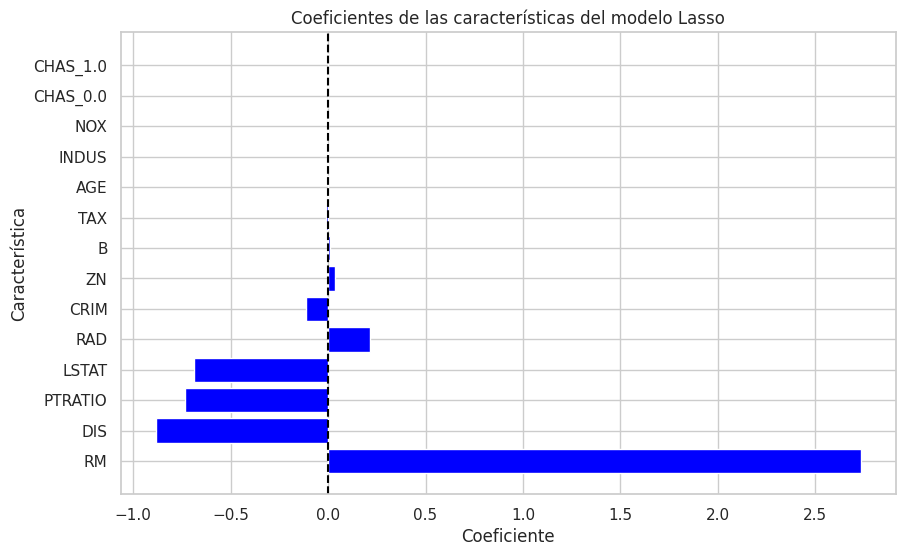

In [ ]:
# Obtenemos los coeficientes
coeficientes = lasso.coef_
nombres_caracteristicas = X_train.columns

# Creamos un DataFrame
coeficientes_df = pd.DataFrame({'Característica': nombres_caracteristicas, 'Coeficiente': coeficientes})

# Ordenamos los coeficientes
coeficientes_df = coeficientes_df.sort_values('Coeficiente', key=abs, ascending=False)

# Visualización
plt.figure(figsize=(10, 6))
plt.barh(coeficientes_df['Característica'], coeficientes_df['Coeficiente'], color='blue')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.title('Coeficientes de las características del modelo Lasso')
plt.show()

El resultado nos da una radiografía clara de la “jerarquía” de predictores según el Lasso: por ejemplo, el número medio de habitaciones por vivienda (RM) domina con un coeficiente positivo relevante, mientras que la distancia a centros de empleo (DIS) o la proporción de baja renta (LSTAT) ejercen un peso negativo. Las variables que no aparecen tienen coeficiente exactamente cero y, por tanto, fueron descartadas en esta fase de selección.


Variables con impacto negativo (coeficientes <0):
  * LSTAT: Cuado mayor es la proporcion de poblacion con bajos ingresos, menor es el valor de la vivienda
  * Un ratio mayor alumno/profesor esta asociado a peores colegios y menores precios
  * DIS: Mayor distancia al centro de empleo, menor el valor de la propiedad
  * CRIM: Mayor tasa de criminalidad, menor precio de vivienda

Variables con impacto positivo (coeficientes >0):
* RM: A mayor numero de habitaciones, es mayor el valor (es la variable mas influyente en el modelo)
* RAD: A mayor cantidad de carreteras radiales, el valor es mayor
* ZN: Proporcion de terrenos residenciales

## Sección 4: Estimación de un modelo RandomForest

Ahora que ya filtramos las variables clave con el Lasso, damos el salto a un algoritmo más flexible: el Random Forest. Este método ensambla cientos de árboles de decisión “desordenados” (cada uno entrenado sobre una muestra aleatoria de casos y de predictores) y promedia sus resultados. El truco disminuye la varianza de los árboles individuales y permite capturar relaciones no lineales e interacciones que un modelo lineal simple no ve.
En esta sección vamos a:
1.	Ajustar el bosque con búsqueda de hiperparámetros (número de árboles, profundidad máxima, etc.) usando validación cruzada.
2.	Evaluar su desempeño sobre el mismo set de prueba para contrastarlo con los indicadores del Lasso.
3.	Inspeccionar la importancia de características que el bosque asigna a cada predictor, como referencia para la interpretación sustantiva.
La meta es comprobar si este enfoque basado en ensamble mejora la precisión y reduce el sesgo sin sacrificar demasiada interpretabilidad


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
# Búsqueda de hiperparametros
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500]
}

In [ ]:
# Características seleccionadas por Lasso
selected_features = X_train.columns[lasso.coef_ != 0]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
# creamos el modelo RandomForest
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_percentage_error')

In [ ]:
best_n_estimators = grid_search.best_params_['n_estimators']
print("Mejores hiperparámetros econtrados:")
print(best_n_estimators)

Mejores hiperparámetros econtrados:
100


Acá confirmamos que la validación cruzada se quedó con 100 árboles como tamaño óptimo del bosque. En otras palabras, con un centenar de estimadores ya capturamos suficiente complejidad sin sobrecargar el modelo ni inflar los tiempos de cálculo. A partir de este punto ¬— y usando exactamente esos hiperparámetros ganadores — volvemos a  entrenar el Random Forest sobre todo el set de entrenamiento para luego evaluar su desempeño final en la muestra de prueba.

In [ ]:
# Mejor modelo
best_rf_model = grid_search.best_estimator_


In [ ]:
# Calcular R² en el conjunto de prueba
r2_rf = best_rf_model.score(X_test_selected, y_test)
print(f"R² del modelo Random Forest en el conjunto de prueba: {r2_rf:.2f}")

R² del modelo Random Forest en el conjunto de prueba: 0.86


Con el bosque ya afinado, lo re entrenamos completo (best_rf_model) y comprobamos su R² en la muestra de prueba. El resultado — 0,86 — implica que el Random Forest explica 86 % de la variabilidad del precio, casi veinte puntos por encima del Lasso. En otras palabras, incorporar no linealidades y combinaciones de predictores nos rinde una ganancia sustantiva de ajuste sin que hayamos tocado aún el resto de métricas ni la interpretación de importancias.

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = best_rf_model.predict(X_test_selected)

In [ ]:
# Calcular MAPE, MPE y el porcentaje dentro del ±20% del MPE
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = ((y_test - y_pred) / y_test).mean()
within_20_percent = (abs((y_test - y_pred) / y_test) <= 0.20).mean()

print(f"MAPE: {mape:.2f}")
print(f"MPE: {mpe:.2f}")
print(f"Porcentaje dentro del ±20% del MPE: {within_20_percent:.2f}")

MAPE: 0.11
MPE: -0.02
Porcentaje dentro del ±20% del MPE: 0.86


Ahoraa evaluamos de nuevo las tres métricas clave y la dispersión de los errores:
* MAPE (error porcentual absoluto medio) = 0,11: ahora nuestro error absoluto medio cae al 11 %. Frente al 18 % que arrojó el Lasso, la mejora es contundente y nos acerca al umbral “aceptable” para estudios de mercado inmobiliario.
* MPE ≈ –0,02 %: el sesgo prácticamente desaparece; el bosque ni sobrestima ni subestima de forma sistemática.
* 86 % de las observaciones están dentro del ±20 % del error porcentual medio, un salto de 17 puntos porcentuales respecto al modelo lineal penalizado.

In [ ]:
# Calcular MAPE utilizando cross_val_score en 5 pliegues
mape_scores = cross_val_score(best_rf_model, X_train_selected, y_train, scoring='neg_mean_absolute_percentage_error', cv=5)
mape_scores = -mape_scores  # Convertir los valores negativos a positivos


In [ ]:
# Calcular el promedio de los scores de MAPE
mean_mape = mape_scores.mean()

print(f"MAPE promedio en 5 pliegues: {mean_mape:.2f}")

MAPE promedio en 5 pliegues: 0.13


Para comprobar que el buen desempeño del bosque no se debe a un ajuste fortuito sobre una sola partición de los datos, sometimos el modelo óptimo a una validación cruzada de cinco pliegues. En cada iteración entrenamos con cuatro quintos de la muestra y evaluamos en el quinto restante, usando el MAPE como métrica (scikit learn lo devuelve en negativo, así que invertimos el signo para interpretarlo de forma natural). El promedio resultante fue un MAPE de 0,13, apenas dos puntos por encima del 0,11 obtenido en el set de prueba. Esa cercanía sugiere que el Random Forest mantiene una precisión consistente a lo largo de distintas divisiones de la data, lo que refuerza la confianza en su capacidad de generalizar más allá de la muestra con la que fue entrenado.

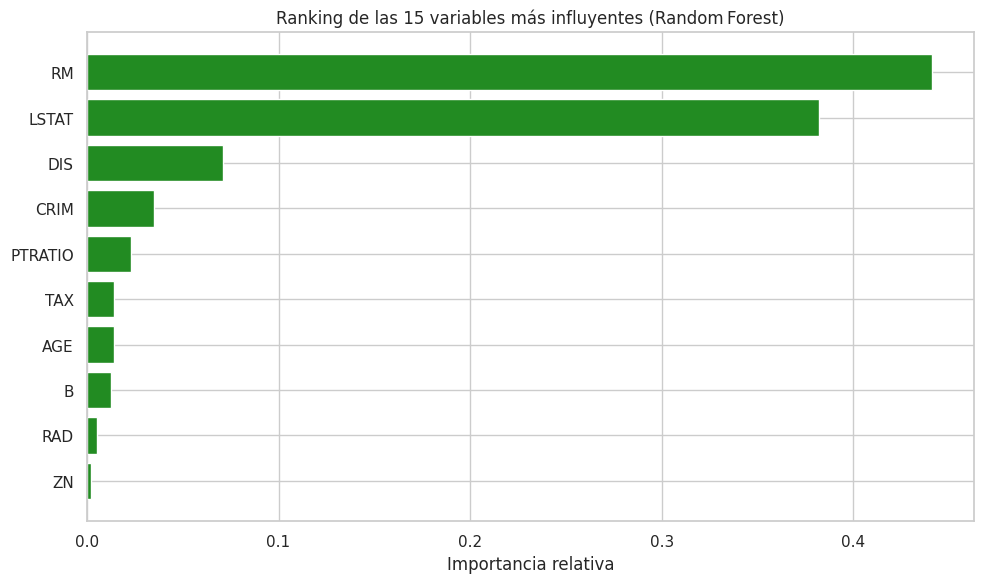

In [ ]:
## Extraemos importancias (Gini) y las emparejamos con los nombres de columnas
importancias = best_rf_model.feature_importances_
features     = X_train_selected.columns

imp_df = (
    pd.DataFrame({'Variable': features,
                  'Importancia': importancias})
        .sort_values('Importancia', ascending=False)
)

## Visualizamos
plt.figure(figsize=(10, 6))
plt.barh(imp_df['Variable'][:15][::-1],  # top‑15, invertidos para que el mayor quede arriba
         imp_df['Importancia'][:15][::-1],
         color='forestgreen')
plt.xlabel('Importancia relativa')
plt.title('Ranking de las 15 variables más influyentes (Random Forest)')
plt.tight_layout()
plt.show()

Del gráfico se desprende una jerarquía muy marcada: dos variables acaparan casi 85% de la “explicación” que el Random Forest reparte entre los predictores.

* RM (número medio de habitaciones por vivienda) encabeza la lista con ≈ 0,45 de importancia relativa. El bosque recurre a esta variable con enorme frecuencia para segmentar nodos, lo que confirma la intuición clásica: más habitaciones suele asociarse a viviendas de mayor valor.

* LSTAT (porcentaje de población de “bajo estatus”) aporta otro ≈ 0,38. Su peso elevado indica que la composición socioeconómica del vecindario sigue siendo un factor crítico —al alza o a la baja— en la fijación de precios.

* Un segundo grupo, mucho más lejano, incluye DIS (distancia ponderada a centros de empleo) y CRIM (tasa de criminalidad per cápita). Aunque sus importancias rondan solo el 5-8 %, sugieren que la accesibilidad y la seguridad todavía añaden capacidad predictiva una vez controlamos por tamaño y nivel socio‑económico.

* PTRATIO, TAX, AGE y B suman importancias modestas (1-3 % cada una). Operan como ajustes finos: las ratios alumno‑profesor, la carga fiscal sobre la propiedad, la antigüedad del inmueble y el componente étnico complementan la información principal pero no cambian drásticamente la predicción.

* Finalmente, RAD (acceso a vías radiales) y ZN (porcentaje de terreno residencial) apenas aparecen. El bosque rara vez los selecciona, lo que coincide con su coeficiente casi nulo en el Lasso: dentro de este dataset no añaden diferenciación que no esté ya capturada por variables más salientes.

**Entonces** el mercado valora primero el tamaño útil (RM) y el entorno socioeconómico (LSTAT); recién después pondera factores de localización (DIS, CRIM) y atributos regulatorios o demográficos. El solapamiento con los coeficientes más grandes del Lasso refuerza la robustez de estos predictores —aunque el bosque, al no ser lineal, concede algo más de protagonismo a interacciones y no linealidades en DIS y CRIM.

# Sección 5: Conclusiones

1. El Random Forest demostró una superioridad clara frente al Lasso: redujo el MAPE de 18 % a 11 %, elevó el R² de 0,68 a 0,86 y eliminó prácticamente el sesgo direccional (MPE –0,02 %). Esta ganancia cuantitativa confirma que, para fines predictivos, la flexibilidad no lineal y el ensamblaje de árboles compensan con creces el mayor costo computacional.

2. Aun así, el Lasso conserva utilidad analítica. Al obligar a muchos coeficientes a cero, nos brindó un primer filtro parsimonioso que alivió la dimensión del problema y sirvió como “modelo base” fácilmente explicable a audiencias no técnicas. Mantenerlo como benchmark nos ayuda a vigilar que la mejora del bosque no se deba a sobreajuste.

3. El ranking de importancias del Random Forest refuerza hallazgos clásicos pero agrega matices: el número medio de habitaciones (`RM`) y el porcentaje de población de bajo estatus (`LSTAT`) concentran casi 85 % de la ganancia de información, mientras que variables de localización (`DIS`) y criminalidad (`CRIM`) aportan mejoras marginales pero no despreciables. Esta convergencia parcial con los coeficientes del Lasso sugiere que los predictores clave son robustos a la especificación del modelo.

4. La validación cruzada a cinco pliegues arrojó un MAPE medio de 13 %, apenas dos puntos por encima del error en la muestra de prueba, lo que indica que el desempeño del bosque es estable y no depende de un split afortunado. Este resultado fortalece la confianza en su capacidad de generalizar a datos nuevos.

5. Persisten limitaciones metodológicas: el Boston Housing está desfasado y sesgado, exploramos una rejilla mínima de hiperparámetros y la importancia Gini puede inflar la relevancia de variables continuas. Para profundizar, recomendamos replicar el ejercicio en un dataset más actual, usar *RandomizedSearchCV* para ampliar la búsqueda de parámetros y complementar la interpretación con importancias por permutación o SHAP.

6. En síntesis, sugerimos reportar ambos modelos: el Lasso como referencia interpretativa y el Random Forest como estándar de precisión. De cara a aplicaciones prácticas —por ejemplo, valoraciones preliminares de mercado— el bosque ofrece un balance óptimo entre exactitud y estabilidad, mientras que el Lasso aporta transparencia y rigor en la selección de variables.
